In [1]:
import sys
print(sys.version)
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ['TF_USE_LEGACY_KERAS'] = "1"
!pip install torch torch_geometric


3.11.4 (main, Jul  5 2023, 13:45:01) [GCC 11.2.0]


In [2]:
import datetime
import copy
import torch
from torch.utils.data import TensorDataset
import logging
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as python_random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from bs4 import BeautifulSoup
#import xml.etree.ElementTree as Xet
from argparse import ArgumentParser
from neuralforecast import NeuralForecast
from neuralforecast.models import TFT
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss
from sklearn.preprocessing import MinMaxScaler
#from nbeats_pytorch.model import NBeatsNet
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm



2025-07-06 18:22:53.950621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751818974.005427  285171 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751818974.021605  285171 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-06 18:22:54.070459: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  war

In [3]:
class DataLoader:
    """
    Load data into desired formats for training/validation/testing, including preprocessing.
    """

    def __init__(self, horizon, back_horizon):
        self.horizon = horizon
        self.back_horizon = back_horizon
        self.scaler = list()
        self.historical_values = list()  # first by patient idx, then by col_idx

    def preprocessing(
        self,
        lst_train_arrays,
        lst_test_arrays,
        # train_mode=True, # flag for train_mode (split into train/val), test_mode (no split)
        train_size=0.8,
        normalize=False,
        sequence_stride=6,
        target_col=0,
        exog_cols=[1, 2, 3, 4],
        horizon=12
    ):
        self.normalize = normalize
        self.sequence_stride = sequence_stride
        self.target_col = target_col
        self.exog_cols = exog_cols
        train_arrays = copy.deepcopy(lst_train_arrays)
        test_arrays = copy.deepcopy(lst_test_arrays)
        # count valid timesteps for each individual series
        # train_array.shape = n_timesteps x n_features
        self.valid_steps_train = [train_array.shape[0] for train_array in train_arrays]
        train_lst, val_lst, test_lst = list(), list(), list()
        for idx in range(len(train_arrays)):
            #print(idx, "index")
            bg_sample_train = train_arrays[idx]
            #bg_sample_train_exog = np.delete(train_arrays[idx], 0, 1)
            bg_sample_test = test_arrays[idx]#[:, target_col]
            #bg_sample_test_exog = np.delete(test_arrays[idx], 0, 1)
            valid_steps_sample = self.valid_steps_train[idx]
            #train_target = bg_sample_train_target[: int(train_size * valid_steps_sample)].copy()
            train = bg_sample_train[: int(train_size * valid_steps_sample), :].copy()
            #val_target = bg_sample_train_target[int(train_size * valid_steps_sample) :].copy()
            val = bg_sample_train[int(train_size * valid_steps_sample) :, :].copy()
            #test_target = bg_sample_test_target[:].copy()
            test = bg_sample_test[:, :].copy()
            if self.normalize:
                scaler_cols = list()
                # train.shape = n_train_timesteps x n_features
                for col_idx in range(train.shape[1]):
                    scaler = MinMaxScaler(feature_range=(0, 1), clip=False)
                    train[:, col_idx] = remove_extra_dim(
                        scaler.fit_transform((add_extra_dim(train[:, col_idx])))
                    )
                    val[:, col_idx] = remove_extra_dim(
                        scaler.transform(add_extra_dim(val[:, col_idx]))
                    )
                    test[:, col_idx] = remove_extra_dim(
                        scaler.transform(add_extra_dim(test[:, col_idx]))
                    )
                    scaler_cols.append(scaler)  # by col_idx, each feature
                self.scaler.append(scaler_cols)  # by pat_idx, each patient
                
            lst_hist_values = list()
            for col_idx in range(train.shape[1]):
                all_train_col = np.concatenate((train[:, col_idx], val[:, col_idx]))
                # decimals = 1, 2 OR 3?
                unique_values = np.unique(np.round(all_train_col, decimals=2))
                lst_hist_values.append(unique_values)
            self.historical_values.append(lst_hist_values)

            train_lst.append(train)
            #train_lst_exog.append(train_exog)
            val_lst.append(val)
            #val_lst_exog.append(val_exog)
            test_lst.append(test)
            #test_lst_exog.append(test_exog)
        

        (
            self.X_train_exog,
            self.X_train_target,
            self.Y_train,#_exog,
            #self.Y_train_target,
            self.train_idxs,
        ) = self.create_sequences(
            train_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_val_exog,
            self.X_val_target,
            self.Y_val,#_exog,
            #self.Y_val_target,
            self.val_idxs,
        ) = self.create_sequences(
            val_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_test_exog,
            self.X_test_target,
            self.Y_test,#_exog,
            #self.Y_test_target,
            self.test_idxs,
        ) = self.create_sequences(
            test_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_reg_exog,
            self.X_reg_target,
            self.reg_idxs,
        ) = self.create_sequences_reg(
            test_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_reg_val_exog,
            self.X_reg_val_target,
            self.reg_val_idxs,
        ) = self.create_sequences_reg(
            test_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        
    @staticmethod
    def create_sequences(
        series_lst, horizon, back_horizon, sequence_stride, target_col=0, exog=False
    ):
        X_exogs, X_targets, Ys, sample_idxs = list(), list(), list(), list()
        
        cnt_nans = 0
        for idx, series in enumerate(series_lst):
            len_series = series.shape[0]
            if len_series < (horizon + back_horizon):
                print(
                    f"Warning: not enough timesteps to split for sample {idx}, len: {len_series}, horizon: {horizon}, back: {back_horizon}."
                )
            for i in range(0, len_series - back_horizon - horizon, sequence_stride):
                input_series_exog = series[i : (i + back_horizon)]
                input_series_exog = np.delete(input_series_exog, [target_col], axis=1)
                input_series_target = series[i : (i + back_horizon), [target_col]]
                output_series = series[
                    (i + back_horizon) : (i + back_horizon + horizon), [target_col]
                ]
                #input_series_exog = np.delete(input_series_exog, [target_col], axis=1)
                #input_series_target = series[i : (i + back_horizon), [target_col]]
                #input_series_target = series[(i + back_horizon) : (i + back_horizon + horizon), [target_col]]
                
                # TODO: add future plans as additional variables (?)
                if np.isfinite(input_series_exog).all() and np.isfinite(input_series_target).all() and np.isfinite(output_series).all():
                    X_exogs.append(input_series_exog)
                    X_targets.append(input_series_target)
                    Ys.append(output_series)
                    #Xs_target.append(input_series_target)
                    # record the sample index when splitting
                    sample_idxs.append(idx)
                else:
                    cnt_nans += 1
                    if cnt_nans % 100 == 0:
                        print(f"{cnt_nans} strides skipped due to NaN values.")
                        
        #print("train", np.array(Xs), "test", np.array(Ys), "val", np.array(sample_idxs))
        return np.array(X_exogs), np.array(X_targets), np.array(Ys), np.array(sample_idxs)

    @staticmethod
    def create_sequences_reg(
        series_lst, horizon, back_horizon, sequence_stride, target_col=0, exog=False
    ):
        Xs_exog, Xs_target, sample_idxs = list(), list(), list()
        
        cnt_nans = 0
        for idx, series in enumerate(series_lst):
            len_series = series.shape[0]
            if len_series < (horizon + back_horizon):
                print(
                    f"Warning: not enough timesteps to split for sample {idx}, len: {len_series}, horizon: {horizon}, back: {back_horizon}."
                )
            for i in range(0, len_series - back_horizon - horizon, sequence_stride):
                output_series_exog = series[(i + back_horizon) : (i + back_horizon + horizon)]
                output_series_exog = np.delete(output_series_exog, [target_col], axis=1)
                output_series_target = series[(i + back_horizon) : (i + back_horizon + horizon), [target_col]]
                # TODO: add future plans as additional variables (?)
                if np.isfinite(output_series_exog).all() and np.isfinite(output_series_target).all():
                    Xs_exog.append(output_series_exog)
                    Xs_target.append(output_series_target)
                    # record the sample index when splitting
                    sample_idxs.append(idx)
                else:
                    cnt_nans += 1
                    if cnt_nans % 100 == 0:
                        print(f"{cnt_nans} strides skipped due to NaN values.")
                        
        #print("train", np.array(Xs), "test", np.array(Ys), "val", np.array(sample_idxs))
        return np.array(Xs_exog), np.array(Xs_target), np.array(sample_idxs)      


In [4]:
# remove an extra dimension
def remove_extra_dim(input_array):
    # 2d to 1d
    if len(input_array.shape) == 2:
        return np.reshape(input_array, (-1))
    # 3d to 2d (remove the last empty dim)
    elif len(input_array.shape) == 3:
        return np.squeeze(np.asarray(input_array), axis=-1)
    else:
        print("Not implemented.")
        #print(input_array, "JLNA;iknb")

# add an extra dimension
def add_extra_dim(input_array):
    # 1d to 2d
    if len(input_array.shape) == 1:
        return np.reshape(input_array, (-1, 1))
    # 2d to 3d
    elif len(input_array.shape) == 2:
        return np.asarray(input_array)[:, :, np.newaxis]
    else:
        print("Not implemented.")
        #print(input_array, "ALVNAPNV")

# Method: Fix the random seeds to get consistent models
def reset_seeds(seed_value=39):
    # ref: https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    # necessary for starting Numpy generated random numbers in a well-defined initial state.
    np.random.seed(seed_value)
    # necessary for starting core Python generated random numbers in a well-defined state.
    python_random.seed(seed_value)
    # set_seed() will make random number generation
    tf.random.set_seed(seed_value)  

In [5]:
def prepare_data(dataset, data_path):
    df_train = []
    df_test = []
    df_train = pd.DataFrame(df_train)
    df_test = pd.DataFrame(df_test)
    if dataset == "simulated":
        for i,j in zip(["01","02","03","04","05","06","07","08","09","10"],[1,2,3,4,5,6,7,8,9,10]):
            a = pd.read_csv(f"../results/simulation_4/adult#0{i}.csv")
            a["Time"] = a[["Time"]].apply(
                lambda x: pd.to_datetime(x, errors="coerce", format="%Y-%m-%d %H:%M:%S")
            )
            #a['Time'] = pd.to_datetime(a['Time'])
            #a.rename(columns={"Time":"ds", "BG":"y"}, inplace=True)
            a = a.dropna()
            #date_index = pd.date_range(a.Time[0], periods=len(a),freq='3min')
            #a.index = date_index
            a['patient_id'] = pd.Series([f"{j}" for x in range(len(a.index))])
            idx = int(a.shape[0] * 0.8)
            cut = a.iloc[idx].Time
            a_train = a[a.Time<cut]
            a_test = a[a.Time>=cut]
            #print("TETSTSETS", idx, cut, a_train, a_test)
            df_train = pd.concat([df_train, a_train], ignore_index=True)
            df_test = pd.concat([df_test, a_test], ignore_index=True)
        
        #df.drop(['Time','BG','LBGI','HBGI','Risk'], axis=1, inplace=True)
        #print("aldingvapnb[", df)
        #idx = int(df.shape[0] * 0.8)#TEST_SIZE)
        #cut = int((df.shape[0]-idx)/10)
        #cut = df.iloc[idx]
        #print("IDX", idx)
        #print("CUT", cut)
        #print("DF.Values", df.values)
        #print("<CUT", df[df.Time<cut].values)
        #print(">CUT", df[df.Time>=cut].values)
        #Y_train_df = df[df.CGM<df['CGM'].values[-cut]] # 132 train
        #Y_test_df = df[df.CGM>=df['CGM'].values[-cut]].reset_index(drop=True) # 12 test 
        #Y_train_df = df.values[:cut]
        #Y_test_df = df.values[cut:]
        #print("Stom kut ding", Y_train_df, "BAH", Y_test_df)
        df_train.to_csv("data/data_simulation/all_train.csv")
        df_test.to_csv("data/data_simulation/all_test.csv")
        #df.drop(['Time','BG','LBGI','HBGI','Risk'], axis=1, inplace=True)
        #return df
        
    elif dataset == "ohiot1dm":
        train = []
        test = []
        train = pd.DataFrame(train)
        test = pd.DataFrame(test)
        for i in [540, 544, 552, 567, 584, 596, 559, 563, 570, 575, 588, 591]:
            file_train = pd.read_csv(data_path + "data_OhioT1DM/" + f"{i}_train.csv")
            file_test = pd.read_csv(data_path + "data_OhioT1DM/" + f"{i}_test.csv")
            
            file_train['patient_id'] = pd.Series([f"{i}" for x in range(len(file_train.index))])
            file_test['patient_id'] = pd.Series([f"{i}" for x in range(len(file_test.index))])
            
            train = pd.concat([train, file_train], ignore_index=True)
            test = pd.concat([train, file_test], ignore_index=True)
            
        train.to_csv(data_path + "data_OhioT1DM/all_train.csv")
        test.to_csv(data_path + "data_OhioT1DM/all_test.csv")
        

In [6]:
def load_data(dataset, data_path):
    prepare_data(dataset, data_path)
    if dataset == "ohiot1dm":
        train, orig_train = load_ohio_data(data_path, "all_train.csv")
        test, orig_test = load_ohio_data(data_path, "all_test.csv")
    elif dataset == "simulated":
        train, orig_train = load_sim_data(data_path, "all_train.csv")
        test, orig_test = load_sim_data(data_path, "all_test.csv")
    elif dataset == "mimic":
        train, orig_train = load_mimic_data(os.path.join(data_path, "data_MIMIC/"))
        test, orig_test = load_mimic_data(os.path.join(data_path, "data_MIMIC/"))  # same for now
    else:
        print("No dataset chosen")
    return train, test, orig_train, orig_test

def load_ohio_data(data_path, file_name="all_train.csv"):
    # load all the patients, combined
    data = pd.read_csv(data_path + "data_OhioT1DM/" + file_name)

    from functools import reduce
    from operator import or_ as union

    def idx_union(mylist):
        idx = reduce(union, (index for index in mylist))
        return idx

    idx_missing = data.loc[data["missing"] != -1].index
    idx_missing_union = idx_union([idx_missing - 1, idx_missing])

    data = data.drop(idx_missing_union)
    data_bg = data[
        [
            "index_new",
            "patient_id",
            "glucose",
            "basal",
            "bolus",
            "carbs",
            "exercise_intensity",
        ]
    ]
    data_bg["time"] = data_bg[["index_new"]].apply(
        lambda x: pd.to_datetime(x, errors="coerce", format="%Y-%m-%d %H:%M:%S")
    )
    data_bg = data_bg.drop("index_new", axis=1)

    data_bg["bolus"][data_bg["bolus"] == -1] = 0
    data_bg["carbs"][data_bg["carbs"] == -1] = 0
    data_bg["exercise_intensity"][data_bg["exercise_intensity"] == -1] = 0
    data_bg["glucose"][data_bg["glucose"] == -1] = np.NaN

    lst_patient_id = [
        540,
        544,
        552,
        567,
        584,
        596,
        559,
        563,
        570,
        575,
        588,
        591,
    ]
    lst_arrays = list()
    for pat_id in lst_patient_id:
        lst_arrays.append(
            np.asarray(
                data_bg[data_bg["patient_id"] == pat_id][
                    [
                        "glucose",
                        "basal",
                        "bolus",
                        "carbs",
                        "exercise_intensity",
                    ]
                ]
            )
        )
    return lst_arrays, data_bg


def load_sim_data(data_path, file_name="all_train.csv"):
    data = pd.read_csv(data_path + "data_simulation/" + file_name)
    data_bg = data[["patient_id", "Time", "CGM", "CHO", "insulin"]]
    print("DATA", data_bg)
    data_bg["time"] = data_bg[["Time"]].apply(
        lambda x: pd.to_datetime(x, errors="coerce", format="%Y-%m-%d %H:%M:%S")
    )
    data_bg = data_bg.drop("Time", axis=1)
    lst_patient_id = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    lst_arrays = list()
    for pat_id in lst_patient_id:
        lst_arrays.append(
            np.asarray(
                data_bg[data_bg["patient_id"] == pat_id][["CGM", "CHO", "insulin"]]
            )
        )
    return lst_arrays, data_bg


def load_mimic_data(data_path, cluster_prefix="cluster_", n_clusters=4):
    """
    Loads clustered MIMIC time series from CSVs per cluster.

    Returns:
        lst_arrays: List of [n_samples x timesteps x features]
        df_combined: All time series as long DataFrame
    """
    lst_arrays = []
    records = []

    for cid in range(n_clusters):
        cluster_dir = os.path.join(data_path, f"{cluster_prefix}{cid}")
        csv_files = sorted([f for f in os.listdir(cluster_dir) if f.endswith(".csv")])

        for fname in csv_files:
            fpath = os.path.join(cluster_dir, fname)
            df = pd.read_csv(fpath)

            # Save 3D array
            features = df.drop(columns=["label_30d", "label_1y", "label_2y"]).values
            lst_arrays.append(features)

            # For tracking in full DataFrame
            df["cluster"] = cid
            df["sample_id"] = fname.replace(".csv", "")
            records.append(df)

    df_combined = pd.concat(records, ignore_index=True)
    return lst_arrays, df_combined


In [7]:
def forecast_metrics(dataset, Y_pred, inverse_transform=True):
    Y_test_original, Y_pred_original = list(), list()
    #Y_pred = np.squeeze(Y_pred, axis=-1)
    if inverse_transform:
        for i in range(dataset.X_test_exog.shape[0]): #test? reg?
            #print("Y_test", dataset.Y_test[i], "Y_pred", Y_pred[i])
            idx = dataset.test_idxs[i]
            scaler = dataset.scaler[idx]

            Y_test_original.append(
                scaler[dataset.target_col].inverse_transform(dataset.Y_test[i])
            )
            Y_pred_original.append(
                scaler[dataset.target_col].inverse_transform(Y_pred[i].numpy().reshape(-1,1))#Y_pred[i])
            )

        Y_test_original = np.array(Y_test_original)
        Y_pred_original = np.array(Y_pred_original)
    else:
        Y_test_original = dataset.Y_test
        Y_pred_original = Y_pred

    def smape(Y_test, Y_pred):
        # src: https://github.com/ServiceNow/N-BEATS/blob/c746a4f13ffc957487e0c3279b182c3030836053/common/metrics.py
        def smape_sample(actual, forecast):
            return 200 * np.mean(
                np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast))
            )

        return np.mean([smape_sample(Y_test[i], Y_pred[i]) for i in range(len(Y_pred))])

    def rmse(Y_test, Y_pred):
        return np.sqrt(np.mean((Y_pred - Y_test) ** 2))
    #print("Y_pred", Y_pred_original)
    #print("test", Y_test_original, "pred", Y_pred_original)
    mean_smape = smape(Y_test_original, Y_pred_original)
    mean_rmse = rmse(Y_test_original, Y_pred_original)

    return mean_smape, mean_rmse

def forecast_metrics_single(Y_orig, Y_pred, inverse_transform=True):
    Y_test_original, Y_pred_original = list(), list()
    #Y_pred = np.squeeze(Y_pred, axis=-1)
    if inverse_transform:
        #for i in range(dataset.X_test_exog.shape[0]):
            #print("Y_test", dataset.Y_test[i], "Y_pred", Y_pred[i])
        #    idx = dataset.test_idxs[i]
        scaler = dataset.scaler[dataset.test_idxs[i]][TARGET_COL]
        
        Y_test_original = scaler.inverse_transform(Y_orig)  # Ensure correct shape
        Y_pred_original = scaler.inverse_transform(Y_pred.numpy().reshape(-1, 1))  # Ensure correct shape


        Y_test_original = np.array(Y_test_original)
        Y_pred_original = np.array(Y_pred_original)
    else:
        Y_test_original = dataset.X_test_target
        Y_pred_original = Y_pred

    def smape(Y_test, Y_pred):
        # src: https://github.com/ServiceNow/N-BEATS/blob/c746a4f13ffc957487e0c3279b182c3030836053/common/metrics.py
        def smape_sample(actual, forecast):
            return 200 * np.mean(
                np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast))
            )

        return np.mean([smape_sample(Y_test[i], Y_pred[i]) for i in range(len(Y_pred))])

    def rmse(Y_test, Y_pred):
        return np.sqrt(np.mean((Y_pred - Y_test) ** 2))
    #print("test", Y_test_original, "pred", Y_pred_original)
    mean_smape = smape(Y_test_original, Y_pred_original)
    mean_rmse = rmse(Y_test_original, Y_pred_original)

    return mean_smape, mean_rmse


def polynomial_values(shift, change_percent, poly_order, horizon, desired_steps=None):
    """
    shift: e.g., +0.1 (110% of the start value)
    change_percent: e.g., 0.1 (10% increase)
    poly_order: e.g., order 1, or 2, ...
    horizon: the forecasting horizon
    desired_steps: the desired timesteps for the change_percent to finally happen (can be larger than horizon)
    """
    if horizon == 1:
        return np.asarray([shift + change_percent])
    desired_steps = desired_steps if desired_steps else horizon

    p_orders = [shift]  # intercept
    p_orders.extend([0 for i in range(poly_order)])
    p_orders[-1] = change_percent / ((desired_steps - 1) ** poly_order)

    p = np.polynomial.Polynomial(p_orders)
    p_coefs = list(reversed(p.coef))
    value_lst = np.asarray([np.polyval(p_coefs, i) for i in range(desired_steps)])

    return value_lst[:horizon]


def generate_bounds(
    center,
    shift,
    desired_center,
    poly_order,
    horizon,
    fraction_std,
    input_series,
    desired_steps,
):
    if input_series[-1] == 0:
        center = "mean"
    if center == "last":
        start_value = input_series[-1]
    elif center == "median":
        start_value = np.median(input_series)
    elif center == "mean":
        start_value = np.mean(input_series)
    elif center == "min":
        start_value = np.min(input_series)
    elif center == "max":
        start_value = np.max(input_series)
    else:
        print("Center: not implemented.")

    std = np.std(input_series)
    # Calculate the change_percent based on the desired center (in 2 hours)
    change_percent = (desired_center - start_value) / start_value
    # Create a default fluctuating range for the upper and lower bound if std is too small
    fluct_range = fraction_std * std if fraction_std * std >= 0.025 else 0.025
    upper = add_extra_dim(
        start_value
        * (
            1
            + polynomial_values(
                shift, change_percent, poly_order, horizon, desired_steps
            )
            + fluct_range
        )
    )
    lower = add_extra_dim(
        start_value
        * (
            1
            + polynomial_values(
                shift, change_percent, poly_order, horizon, desired_steps
            )
            - fluct_range
        )
    )
    return upper, lower

In [8]:
parser = ArgumentParser()
parser.add_argument( "--dataset", type=str, help="Choose dataset.")
parser.add_argument( "--horizon", type=int, help="Horizon of forecasting task.")
parser.add_argument( "--back-horizon", type=int, help="Back horizon of forecasting task.")
parser.add_argument( "--random-seed", type=int, default=39, help="Random seed parameter, default 39.")
parser.add_argument( "--train-size", type=float, default=0.8, help="Proportional size of the training set.")
parser.add_argument( "--test-group", type=str, default=None, help="Extract random 100 samples from test group, i.e., 'hyper'/'hypo'; default None.")
# Parse the arguments from a string
args = parser.parse_args("--dataset ohiot1dm --horizon 6 --back-horizon 24 --random-seed 32 --train-size 0.8 --test-group hyper".split())
#args = parser.parse_args("--dataset simulated --horizon 10 --back-horizon 40 --random-seed 32 --train-size 0.8 --test-group hyper".split())
#args = parser.parse_args("--dataset mimic --horizon 6 --back-horizon 12 --random-seed 32 --train-size 0.8 --test-group hyper".split())
#args = parser.parse_args()
data_path = "./data/"
lst_arrays, lst_arrays_test, orig_train, orig_test = load_data(args.dataset, data_path) #misschien toch load_data gebruiken?
#print(lst_arrays, orig_train)
print(f"The shape of loaded train: {len(lst_arrays)}*{lst_arrays[0].shape}")
print(f"The shape of test: {len(lst_arrays_test)}*{lst_arrays_test[0].shape}")

print(f"===========Desired trend parameters=============")
center = "last"
desired_shift, poly_order = 0, 1
fraction_std = 1#args.fraction_std
print(f"center: {center}, desired_shift: {desired_shift};")
print(f"fraction_std:{fraction_std};")
print(f"desired_change:'sample_based', poly_order:{poly_order}.")

TARGET_COL = 0
if args.dataset == "ohiot1dm":
    CHANGE_COLS = [1, 2, 3, 4]
elif args.dataset == "simulated":
    CHANGE_COLS = [1, 2]
elif args.dataset == "mimic": #??? more
    CHANGE_COLS = [1, 2, 3, 4]
else:
    CHANGE_COLS = None

RANDOM_STATE = args.random_seed
TRAIN_SIZE = args.train_size
horizon, back_horizon = args.horizon, args.back_horizon
dataset = DataLoader(horizon, back_horizon)
dataset.preprocessing(#???
    lst_train_arrays=lst_arrays,
    lst_test_arrays=lst_arrays_test,
    train_size=TRAIN_SIZE,
    normalize=True,
    sequence_stride= horizon,
    target_col=TARGET_COL,
    exog_cols=CHANGE_COLS,
    horizon = horizon
)

#print(dataset.X_train.shape, dataset.Y_train.shape)
#print(dataset.X_val.shape, dataset.Y_val.shape)
#print(dataset.X_test.shape, dataset.Y_test.shape)

# Define N-BEATS Block
class NBeatsBlock(layers.Layer):
    def __init__(self, units, horizon, n_in_features, **kwargs):
        super(NBeatsBlock, self).__init__(**kwargs)
        self.fc1 = layers.Dense(units, activation="relu")
        self.fc2 = layers.Dense(units, activation="relu")
        self.fc3 = layers.Dense(units, activation="relu")
        self.fc4 = layers.Dense(units, activation="relu")
        self.backcast = layers.Dense(horizon * n_in_features, activation="linear")  
        self.forecast = layers.Dense(horizon * n_in_features, activation="linear")  

    def call(self, inputs):
        x = self.fc1(inputs)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        backcast = self.backcast(x)
        forecast = self.forecast(x)
        return forecast

def build_nbeats_model(back_horizon, n_in_features, horizon, units=512):
    inputs = keras.Input(shape=(back_horizon, n_in_features))
    x = layers.Flatten()(inputs)  # Flatten time series input

    # Stack multiple N-BEATS blocks
    x = NBeatsBlock(units, horizon, n_in_features)(x)
    x = tf.reshape(x, (-1, horizon, n_in_features))  # Reshape to match output shape

    model = keras.Model(inputs, x)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="mae")
    return model

print("Shape", dataset.X_train_exog.shape, dataset.X_train_target.shape, dataset.Y_train.shape, dataset.X_test_exog.shape, dataset.X_test_target.shape)
X_train = np.concatenate((dataset.X_train_exog, dataset.X_train_target), axis=-1)
y_train = dataset.Y_train
X_test = np.concatenate((dataset.X_test_exog, dataset.X_test_target), axis=-1)
y_test = dataset.Y_test
X_val = np.concatenate((dataset.X_val_exog, dataset.X_val_target), axis=-1)
y_val = dataset.Y_val
print("Test", X_train, y_train)
exog_train = dataset.X_train_exog
exog_test = dataset.X_test_exog
exog_val = dataset.X_val_exog

tf.random.set_seed(args.random_seed)

n_in_features = X_train.shape[2]
n_out_features = 1
n_exog_features = exog_train.shape[2]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0.0001, patience=10, restore_best_weights=True
)
#if args.forecast_model == "gru":
forecast_GRU = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(back_horizon, n_in_features)),
    tf.keras.layers.GRU(200, activation="tanh", return_sequences=True), #200 testen
    tf.keras.layers.GRU(200, activation="tanh", return_sequences=False),
    tf.keras.layers.Dense(horizon * n_in_features, activation="linear"),
    tf.keras.layers.Reshape((horizon, n_in_features))
])

forecast_GRU.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss="mae")
#tf_model_exog.fit(exog_train, exog_train[:, -horizon:, :], epochs=200, batch_size=64, validation_data=(exog_val, exog_val[:, -horizon:, :]), callbacks=[early_stopping])
forecast_GRU.fit(X_train, y_train[:, -horizon:, :], epochs=200, batch_size=64, validation_data=(X_val, y_val[:, -horizon:, :]), callbacks=[early_stopping])


pred_all_GRU = forecast_GRU.predict(X_test)

#elif args.forecast_model == "nbeatsx":
forecast_NBEATS = build_nbeats_model(back_horizon, n_in_features, horizon)
forecast_NBEATS.fit(X_train, y_train[:, -horizon:, :], epochs=200, batch_size=64, validation_data=(X_val, y_val[:, -horizon:, :]), callbacks=[early_stopping])
pred_all_NBEATS = forecast_NBEATS.predict(X_test)




/tmp/ipykernel_285171/3369857583.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bg["time"] = data_bg[["index_new"]].apply(
/tmp/ipykernel_285171/3369857583.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bg["bolus"][data_bg["bolus"] == -1] = 0
/tmp/ipykernel_285171/3369857583.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bg["carbs"][data_bg["carbs

The shape of loaded train: 12*(12236, 5)
The shape of test: 12*(12236, 5)
===========Desired trend parameters=============
center: last, desired_shift: 0;
fraction_std:1;
desired_change:'sample_based', poly_order:1.
100 strides skipped due to NaN values.
200 strides skipped due to NaN values.
300 strides skipped due to NaN values.
400 strides skipped due to NaN values.
500 strides skipped due to NaN values.
600 strides skipped due to NaN values.
700 strides skipped due to NaN values.
800 strides skipped due to NaN values.
900 strides skipped due to NaN values.
1000 strides skipped due to NaN values.
1100 strides skipped due to NaN values.
1200 strides skipped due to NaN values.
1300 strides skipped due to NaN values.
1400 strides skipped due to NaN values.
1500 strides skipped due to NaN values.
1600 strides skipped due to NaN values.
1700 strides skipped due to NaN values.
1800 strides skipped due to NaN values.
1900 strides skipped due to NaN values.
2000 strides skipped due to NaN v

2025-07-06 18:23:56.711592: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/200


2025-07-06 18:23:58.618884: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


256/256 [==============================] - ETA: 0s - loss: 0.0914

2025-07-06 18:24:49.544993: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


256/256 [==============================] - 56s 180ms/step - loss: 0.0914 - val_loss: 0.0495
Epoch 2/200
256/256 [==============================] - 46s 179ms/step - loss: 0.0421 - val_loss: 0.0386
Epoch 3/200
256/256 [==============================] - 53s 209ms/step - loss: 0.0360 - val_loss: 0.0372
Epoch 4/200
256/256 [==============================] - 44s 170ms/step - loss: 0.0335 - val_loss: 0.0333
Epoch 5/200
256/256 [==============================] - 55s 217ms/step - loss: 0.0318 - val_loss: 0.0319
Epoch 6/200
256/256 [==============================] - 47s 183ms/step - loss: 0.0306 - val_loss: 0.0313
Epoch 7/200
256/256 [==============================] - 47s 184ms/step - loss: 0.0299 - val_loss: 0.0318
Epoch 8/200
256/256 [==============================] - 44s 172ms/step - loss: 0.0292 - val_loss: 0.0297
Epoch 9/200
256/256 [==============================] - 49s 192ms/step - loss: 0.0286 - val_loss: 0.0294
Epoch 10/200
256/256 [==============================] - 45s 178ms/step - los

2025-07-06 18:53:50.730851: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


658/658 [==============================] - 35s 49ms/step
Epoch 1/200


2025-07-06 18:54:26.906614: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


255/256 [============================>.] - ETA: 0s - loss: 0.0683

2025-07-06 18:54:36.921777: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


256/256 [==============================] - 11s 31ms/step - loss: 0.0682 - val_loss: 0.0412
Epoch 2/200
256/256 [==============================] - 8s 32ms/step - loss: 0.0368 - val_loss: 0.0369
Epoch 3/200
256/256 [==============================] - 7s 28ms/step - loss: 0.0340 - val_loss: 0.0338
Epoch 4/200
256/256 [==============================] - 6s 24ms/step - loss: 0.0328 - val_loss: 0.0333
Epoch 5/200
256/256 [==============================] - 7s 27ms/step - loss: 0.0317 - val_loss: 0.0324
Epoch 6/200
256/256 [==============================] - 7s 26ms/step - loss: 0.0308 - val_loss: 0.0321
Epoch 7/200
256/256 [==============================] - 7s 29ms/step - loss: 0.0304 - val_loss: 0.0315
Epoch 8/200
256/256 [==============================] - 7s 26ms/step - loss: 0.0299 - val_loss: 0.0317
Epoch 9/200
256/256 [==============================] - 7s 29ms/step - loss: 0.0293 - val_loss: 0.0314
Epoch 10/200
256/256 [==============================] - 8s 31ms/step - loss: 0.0287 - val_los

2025-07-06 18:58:03.646437: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


658/658 [==============================] - 5s 8ms/step


TESTTESTESTESTESTEST: (21025, 6, 5) (21025, 6, 5)
gru model trained, with test sMAPE score 6.1972; test RMSE score: 14.6864.
nbeats model trained, with test sMAPE score 6.1621; test RMSE score: 14.4128.
TEST (21025, 6) (21025, 6)


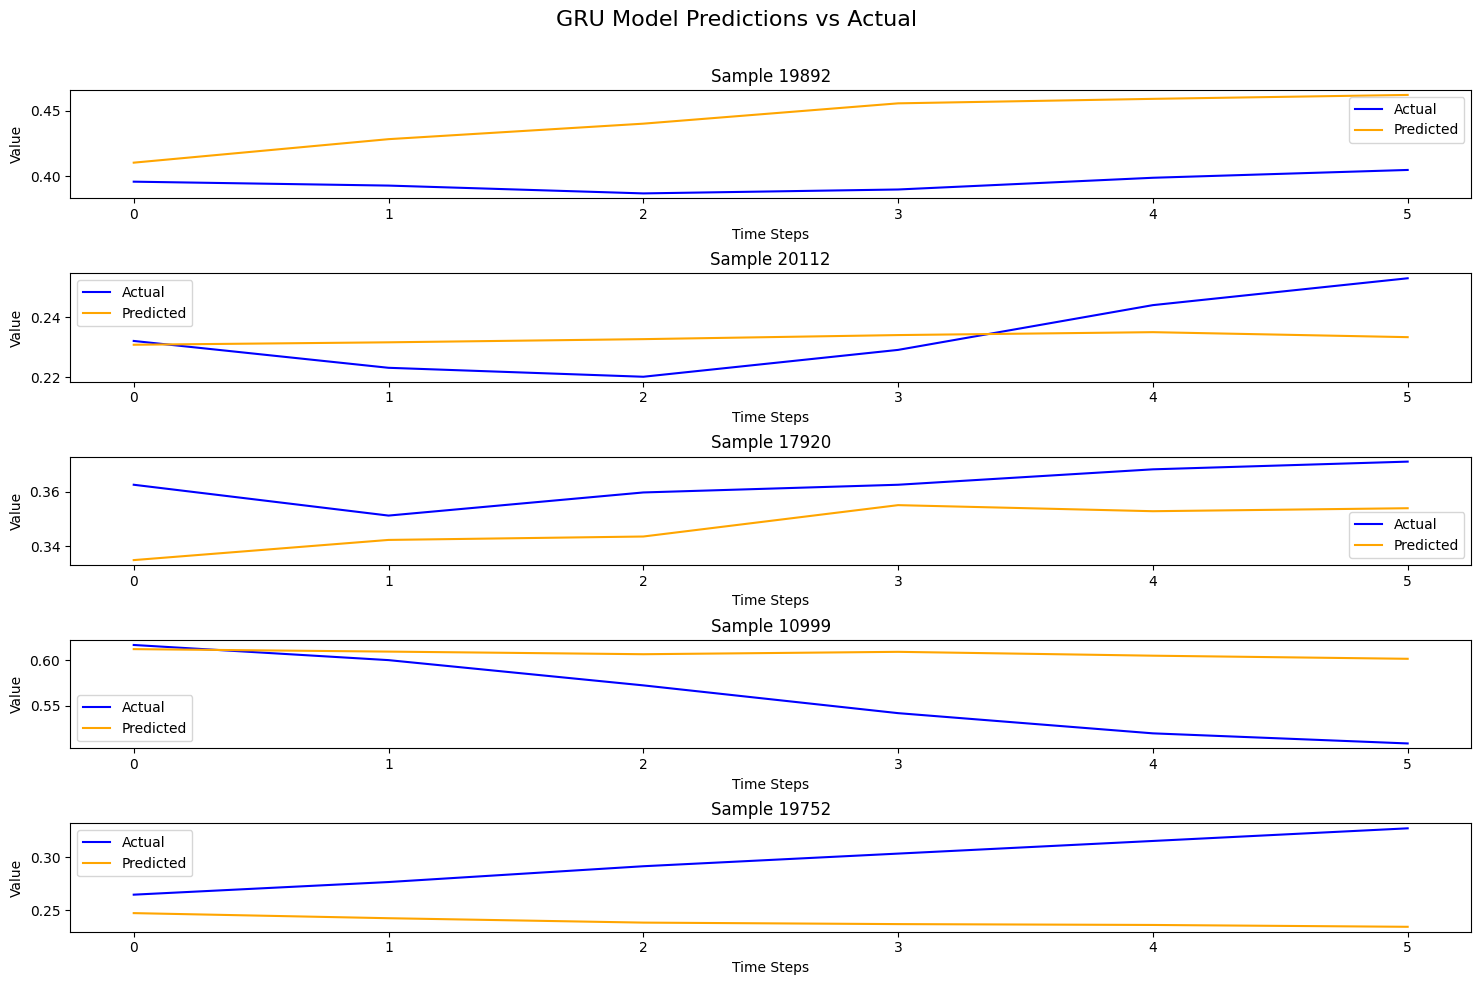

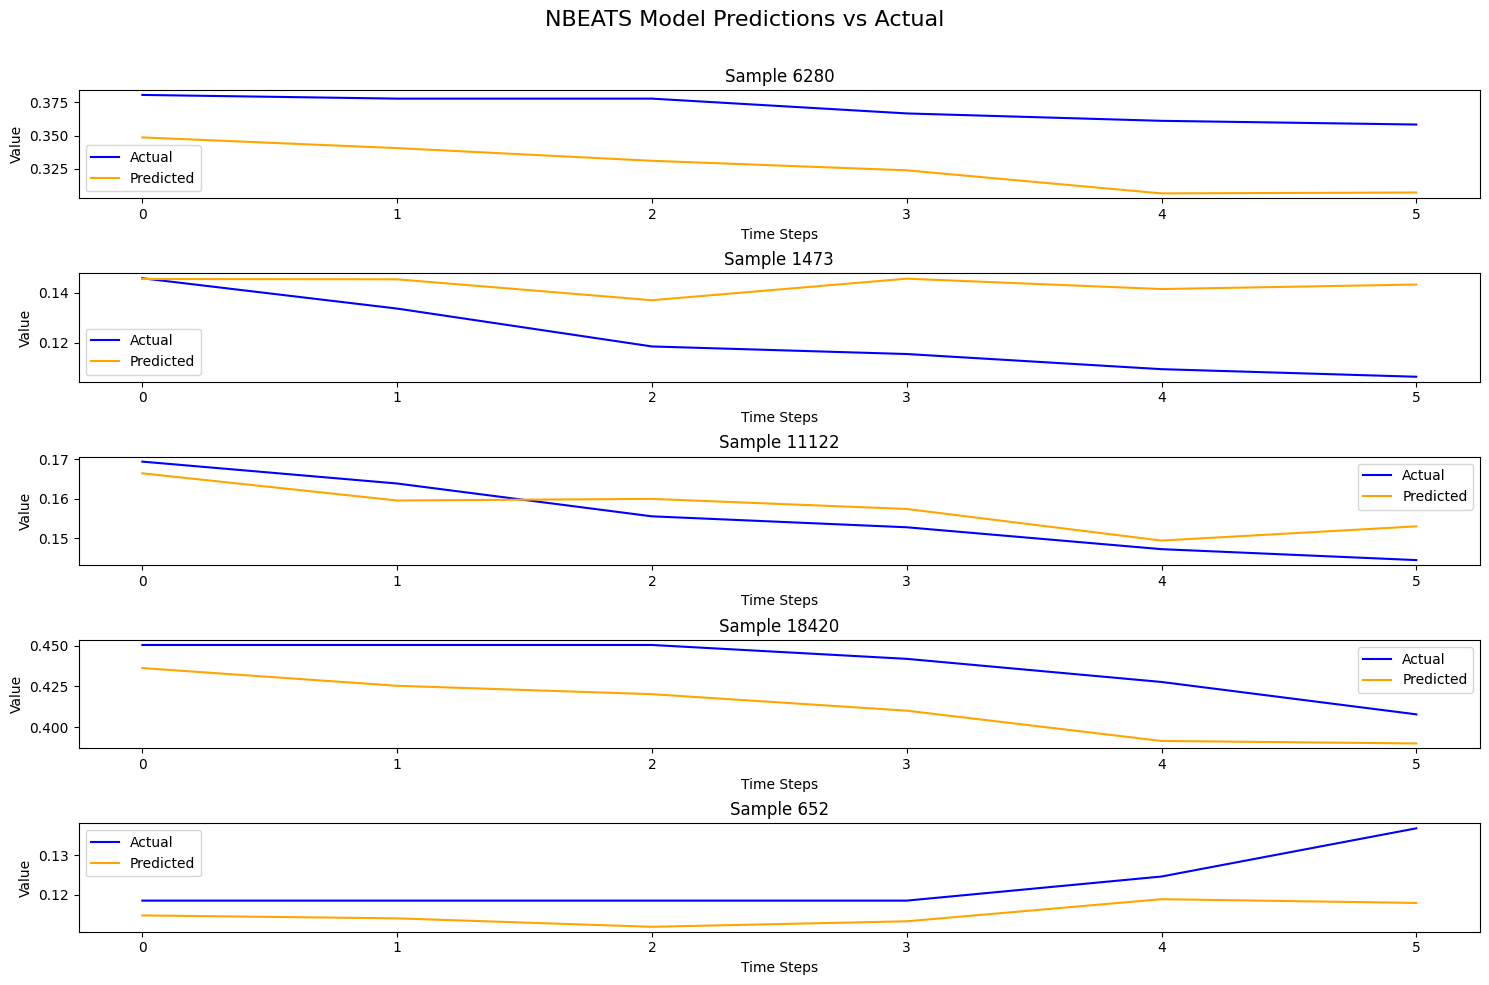

In [9]:
print("TESTTESTESTESTESTEST:", pred_all_GRU.shape, pred_all_NBEATS.shape)
pred_tf_gru = pred_all_GRU[:,:,0]
pred_tf_gru = tf.convert_to_tensor(pred_tf_gru, dtype=tf.float32)
pred_exog_gru = pred_all_GRU[:,:,1:]
pred_tf_nbeats = pred_all_NBEATS[:,:,0]
pred_tf_nbeats = tf.convert_to_tensor(pred_tf_nbeats, dtype=tf.float32)
pred_exog_nbeats = pred_all_NBEATS[:,:,1:]

mean_smape, mean_rmse = forecast_metrics(dataset, pred_tf_gru)
print(
    f"gru model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
)
mean_smape, mean_rmse = forecast_metrics(dataset, pred_tf_nbeats)
print(
    f"nbeats model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
)

def plot_predictions(y_true, y_pred, name, title='Model Predictions vs Actual', num_samples=5):

    # Ensure y_true and y_pred are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Select a random sample of indices to plot
    indices = np.random.choice(y_true.shape[0], num_samples, replace=False)

    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(indices):
        plt.subplot(num_samples, 1, i + 1)
        plt.plot(y_true[idx], label='Actual', color='blue')
        plt.plot(y_pred[idx], label='Predicted', color='orange')
        plt.title(f'Sample {idx + 1}')
        plt.xlabel('Time Steps')
        plt.ylabel('Value')
        plt.legend()
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.9)  # Adjust the top to make room for the title
    plt.savefig(f"plot_predictions{name}.png")
    plt.show()


pred_tf_reshaped_gru = pred_tf_gru.numpy().reshape(-1, horizon)  # Adjust based on your output shape #.numpy()
pred_tf_reshaped_nbeats = pred_tf_nbeats.numpy().reshape(-1, horizon)  # Adjust based on your output shape #.numpy()

y_test_reshaped = dataset.Y_test.reshape(-1, horizon)  # Adjust based on your target shape
print("TEST", pred_tf_reshaped_gru.shape, pred_tf_reshaped_nbeats.shape)#, pred_tf_reshaped_tft.shape, pred_tf_reshaped_nbeatsx.shape, y_test_reshaped.shape)
plot_predictions(y_test_reshaped, pred_tf_reshaped_gru, "gru", title='GRU Model Predictions vs Actual')
plot_predictions(y_test_reshaped, pred_tf_reshaped_nbeats, "nbeats", title='NBEATS Model Predictions vs Actual')
